# 数据预处理
## 生成所有点的gif动态图像
采用的数据集为434个ID的行人在0-540帧的二维坐标数据。固定每个ID的颜色，逐帧生成动画演示

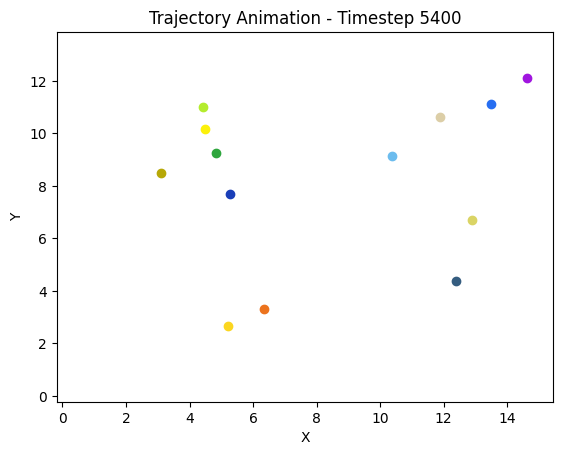

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image

# 读取数据
file_path = r'D:\xjtufiles\undergraduate\2023-2024\spring\ml\Pedestrian clustering\students003.txt'
data = np.loadtxt(file_path)

# 提取数据
timesteps = data[:, 0].astype(int)
ids = data[:, 1].astype(int)
xs = data[:, 2]
ys = data[:, 3]

# 获取唯一的时间步
unique_timesteps = np.unique(timesteps)
unique_ids = np.unique(ids)

# 分配随机颜色
np.random.seed(42)  # 固定种子，以保证相同运行环境的结果一致
colors = np.random.rand(len(unique_ids), 3)

# 设置图形
fig, ax = plt.subplots()
ax.set_xlim(np.min(xs), np.max(xs))
ax.set_ylim(np.min(ys), np.max(ys))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Trajectory Animation')

# 更新每一帧
def update(frame):
    current_timestep = unique_timesteps[frame]
    current_data = data[timesteps == current_timestep]
    ax.clear()
    ax.set_xlim(np.min(xs), np.max(xs))
    ax.set_ylim(np.min(ys), np.max(ys))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'Trajectory Animation - Timestep {current_timestep}')
    
    for i, uid in enumerate(unique_ids):
        user_data = current_data[current_data[:, 1] == uid]
        if len(user_data) > 0:
            ax.scatter(user_data[:, 2], user_data[:, 3], color=colors[i])

# 创建动画
ani = animation.FuncAnimation(fig, update, frames=len(unique_timesteps), repeat=False)

# 保存每一帧为图片
frames = []
for i in range(len(unique_timesteps)):
    update(i)
    plt.savefig(f'preframe_{i}.png')
    frames.append(Image.open(f'preframe_{i}.png'))

# 使用 ImageMagick 合成视频
frames[0].save('pre_trajectory_animation.gif', save_all=True, append_images=frames[1:], duration=200, loop=0)

plt.show()


以每20帧为单位形成路线图

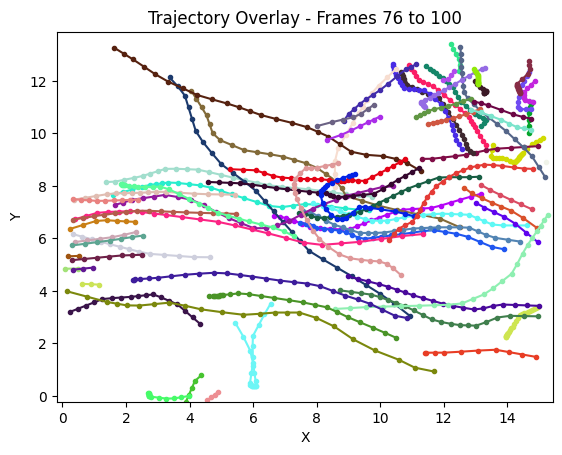

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# 读取数据
file_path = r'D:\xjtufiles\undergraduate\2023-2024\spring\ml\Pedestrian clustering\students003.txt'
data = np.loadtxt(file_path)

# 提取数据
timesteps = data[:, 0].astype(int)
ids = data[:, 1].astype(int)
xs = data[:, 2]
ys = data[:, 3]

# 获取唯一的时间步和唯一的ID
unique_timesteps = np.unique(timesteps)
unique_ids = np.unique(ids)

# 分配随机颜色
np.random.seed(42)  # 固定种子，以保证相同运行环境的结果一致
colors = np.random.rand(len(unique_ids), 3)

# 创建图形
fig, ax = plt.subplots()
ax.set_xlim(np.min(xs), np.max(xs))
ax.set_ylim(np.min(ys), np.max(ys))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Trajectory Overlay - Frames 76 to 100')

# 绘制每个点的轨迹
for uid in unique_ids:
    mask = ids == uid
    user_timesteps = timesteps[mask]
    user_xs = xs[mask]
    user_ys = ys[mask]
    
    # 只绘制指定范围帧的轨迹
    trajectory_mask = (user_timesteps >= unique_timesteps[76]) & (user_timesteps <= unique_timesteps[100])
    ax.plot(user_xs[trajectory_mask], user_ys[trajectory_mask], color=colors[uid-1], marker='o', markersize=3)

# 保存图像
plt.savefig('trajectory_overlay.png')
plt.show()


## 转换为张量
为了便于处理，将数据集转换为434×541×2的张量形式，各维度分别为ID、时间帧与X、Y坐标值，注意到原始数据没有X=0或Y=0的样本，因此设置各ID在未出现的时间帧中X、Y坐标均为0。

In [4]:
import numpy as np

# 读取数据
file_path = r'D:\xjtufiles\undergraduate\2023-2024\spring\ml\Pedestrian clustering\students003.txt'
data = np.loadtxt(file_path)

# 提取数据
timesteps = data[:, 0].astype(int)
ids = data[:, 1].astype(int)
xs = data[:, 2]
ys = data[:, 3]

# 确定唯一的 ID 和时间步
unique_ids = np.unique(ids)
unique_timesteps = np.unique(timesteps)

# 确定张量的形状
num_ids = len(unique_ids)
num_timesteps = len(unique_timesteps)
tensor_shape = (num_ids, num_timesteps, 2)  # 最后一个维度为2，分别对应X和Y

# 创建并初始化张量
tensor = np.zeros(tensor_shape)

# 填充张量
for i, uid in enumerate(unique_ids):
    for j, timestep in enumerate(unique_timesteps):
        idx = np.where((ids == uid) & (timesteps == timestep))[0]
        if len(idx) > 0:
            tensor[i, j, 0] = xs[idx]
            tensor[i, j, 1] = ys[idx]

# 保存张量
np.save('pedestrian_tensor.npy', tensor)


C:\Users\11094\AppData\Local\Temp\ipykernel_808\1545187493.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tensor[i, j, 0] = xs[idx]
C:\Users\11094\AppData\Local\Temp\ipykernel_808\1545187493.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tensor[i, j, 1] = ys[idx]


In [5]:
print(tensor_shape)

(434, 541, 2)


# AGNES
## 计算距离

### 欧氏距离（全局版）

In [77]:
import numpy as np
from scipy.spatial import distance_matrix

# 读取张量
tensor = np.load('pedestrian_tensor.npy')

# 获取张量的形状
num_ids, num_timesteps, _ = tensor.shape

# 初始化一个空矩阵来保存距离之和
distance_matrix_sum = np.zeros((num_ids, num_ids))

# 计算欧氏距离之和
for i in range(num_ids):
    for j in range(num_ids):
        # 获取两个 ID 的坐标
        coords_i = tensor[i, :, :]
        coords_j = tensor[j, :, :]

        # 计算两个 ID 所有时间步的欧氏距离之和
        # 对应时间步的坐标距离之和
        dist_sum = np.sum(np.sqrt(np.sum((coords_i - coords_j) ** 2, axis=1)))
        
        # 保存到矩阵
        distance_matrix_sum[i, j] = dist_sum

# 保存矩阵
np.save('distance_matrix_sum.npy', distance_matrix_sum)

# 输出矩阵
print(distance_matrix_sum)


[[   0.          119.82860806  425.17951304 ...  922.21471903
   447.20698525  676.35754468]
 [ 119.82860806    0.          502.59844597 ...  852.09375658
   377.0860228   606.23658222]
 [ 425.17951304  502.59844597    0.         ... 1232.94826259
   757.94052881  987.09108824]
 ...
 [ 922.21471903  852.09375658 1232.94826259 ...    0.
   928.16774767 1157.3183071 ]
 [ 447.20698525  377.0860228   757.94052881 ...  928.16774767
     0.          682.31057332]
 [ 676.35754468  606.23658222  987.09108824 ... 1157.3183071
   682.31057332    0.        ]]


### 欧氏距离（非全局版）

In [20]:
import numpy as np

# 读取张量
tensor = np.load('pedestrian_tensor.npy')

# 获取张量的形状
num_ids, num_timesteps, _ = tensor.shape

# 初始化一个空矩阵来保存平均距离
average_distance_matrix = np.zeros((num_ids, num_ids))

# 计算欧氏距离的平均数
for i in range(num_ids):
    for j in range(num_ids):
        if i == j:
            continue  # 跳过自身距离的计算
        # 获取两个 ID 的坐标
        coords_i = tensor[i, :, :]
        coords_j = tensor[j, :, :]
        
        # 找到两个 ID 都非零的时间帧
        valid_timesteps = np.all(coords_i != 0, axis=1) & np.all(coords_j != 0, axis=1)
        
        if np.any(valid_timesteps):
            # 计算这些时间帧的欧氏距离
            valid_coords_i = coords_i[valid_timesteps]
            valid_coords_j = coords_j[valid_timesteps]
            dists = np.sqrt(np.sum((valid_coords_i - valid_coords_j) ** 2, axis=1))
            
            # 计算平均距离
            average_dist = np.mean(dists)
        else:
            average_dist = 100000  # 如果没有有效的时间帧，距离设为0
        
        # 保存到矩阵
        average_distance_matrix[i, j] = average_dist

# 保存矩阵
np.save('average_distance_matrix.npy', average_distance_matrix)

# 输出矩阵
print(average_distance_matrix)



[[0.00000000e+00 2.50913679e+00 3.74004916e+00 ... 1.00000000e+05
  1.00000000e+05 1.00000000e+05]
 [2.50913679e+00 0.00000000e+00 6.19000896e+00 ... 1.00000000e+05
  1.00000000e+05 1.00000000e+05]
 [3.74004916e+00 6.19000896e+00 0.00000000e+00 ... 1.00000000e+05
  1.00000000e+05 1.00000000e+05]
 ...
 [1.00000000e+05 1.00000000e+05 1.00000000e+05 ... 0.00000000e+00
  1.00000000e+05 1.00000000e+05]
 [1.00000000e+05 1.00000000e+05 1.00000000e+05 ... 1.00000000e+05
  0.00000000e+00 1.00000000e+05]
 [1.00000000e+05 1.00000000e+05 1.00000000e+05 ... 1.00000000e+05
  1.00000000e+05 0.00000000e+00]]


### 欧氏距离+动量

## 聚类

C:\Users\11094\AppData\Local\Temp\ipykernel_18820\3950075733.py:10: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix_sum, method='ward')  # 选择'ward' 方法，适用于欧式距离矩阵


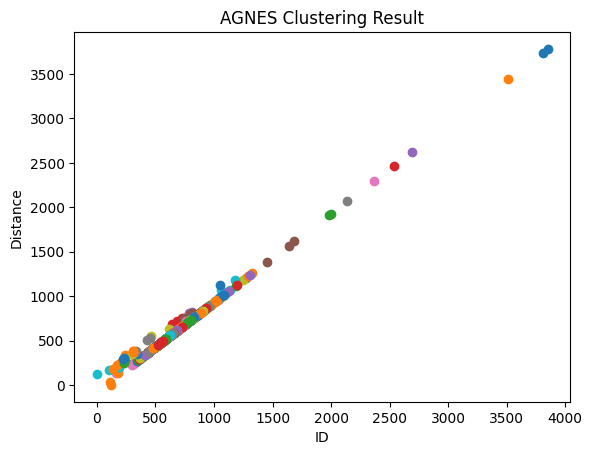

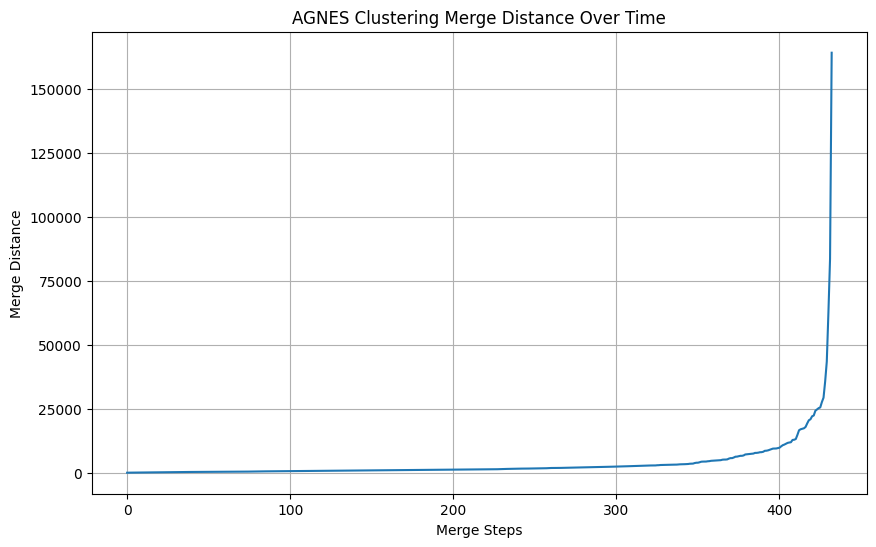

In [82]:
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
import matplotlib.pyplot as plt

# 读取距离矩阵
#distance_matrix_sum = np.load('average_distance_matrix.npy')
distance_matrix_sum = np.load('distance_matrix_sum.npy')

# AGNES 聚类算法
Z = linkage(distance_matrix_sum, method='ward')  # 选择'ward' 方法，适用于欧式距离矩阵
max_clusters = (434-220)  # 可以根据实际需要调整聚类数
clusters = fcluster(Z, max_clusters, criterion='maxclust')

# 保存合并结果距离
merge_distances = []

# 遍历合并过程
for i in range(len(Z)):
    # 合并结果中的每个合并步骤
    merge_distances.append(Z[i, 2])

# 可视化聚类结果
fig, ax = plt.subplots()
for i in range(len(np.unique(clusters))):
    cluster_points = np.argwhere(clusters == i+1)
    ax.scatter(distance_matrix_sum[cluster_points, 0], distance_matrix_sum[cluster_points, 1], label=f'Cluster {i}')

ax.set_xlabel('ID')
ax.set_ylabel('Distance')
ax.set_title('AGNES Clustering Result')
##ax.legend()
plt.show()

# 画折线图展示合并距离变化
plt.figure(figsize=(10, 6))
plt.plot(range(len(merge_distances)), merge_distances)
plt.xlabel('Merge Steps')
plt.ylabel('Merge Distance')
plt.title('AGNES Clustering Merge Distance Over Time')
plt.grid()
plt.show()

# 输出聚类结果
np.savetxt('214_clustered_results.txt', clusters, fmt='%d', delimiter=' ')


In [42]:
print(merge_distances)
print(len(merge_distances))

[1.3615370987432343, 2.0688320358955763, 2.3273642396405574, 2.4412608059167455, 2.47603409222465, 2.5687616965946085, 2.6425357666280065, 2.7831064715380083, 2.8177854708665504, 2.8587989879198914, 2.8598420859505396, 2.9967758759050445, 3.06074490770637, 3.0636335260221843, 3.1087862943779383, 3.121032252101093, 3.1854697799675713, 3.2923655974226285, 3.3001584621144633, 3.3519827910475226, 3.3995338456695356, 3.4020152369487073, 3.4209540525532773, 3.444885377941718, 3.5629841914521307, 3.606661047790133, 3.665086850656325, 3.925284837529584, 3.956907199891938, 4.234025492194761, 4.384463563402512, 4.38750433426426, 4.4867372392299245, 4.587939919124241, 4.616132896135871, 5.230453013533691, 5.4013673116079515, 5.450367758783609, 7.566642664992279, 7.9556354199440955, 8.110994166104788, 8.675019473775809, 9.224801020734782, 11.528680648850484, 12.697724984816391, 12.763008620124042, 13.348278811179586, 14.809625150489447, 17.000826269476573, 19.05408484895952, 19.94646611054875, 20.

# 绘制结果图像

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

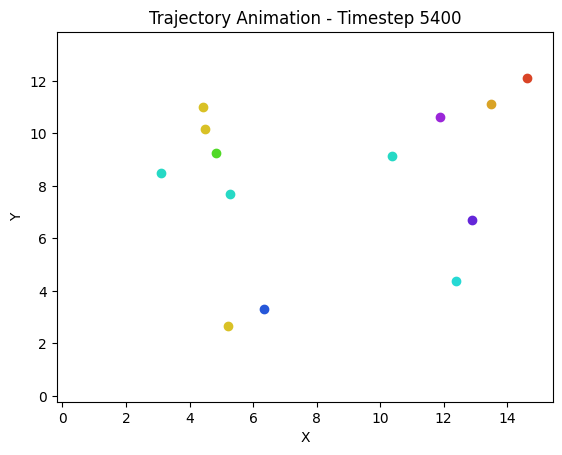

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
import colorsys

# 读取数据
file_path_data = r'D:\xjtufiles\undergraduate\2023-2024\spring\ml\Pedestrian clustering\students003.txt'
data = np.loadtxt(file_path_data)

# 读取聚类结果
file_path_clusters = r'D:\xjtufiles\undergraduate\2023-2024\spring\ml\Pedestrian clustering\214_clustered_results.txt'
clusters = np.loadtxt(file_path_clusters, dtype=int)

# 提取数据
timesteps = data[:, 0].astype(int)
ids = data[:, 1].astype(int)
xs = data[:, 2]
ys = data[:, 3]

# 获取唯一的时间步和唯一的ID
unique_timesteps = np.unique(timesteps)
unique_ids = np.unique(ids)
num_clusters = np.max(clusters)  # 读取聚类的最大类别数

# 生成足够多的不同颜色
def generate_colors(num_colors):
    colors = []
    for i in range(num_colors):
        hue = i / num_colors
        lightness = 0.5
        saturation = 0.7
        rgb = colorsys.hls_to_rgb(hue, lightness, saturation)
        colors.append(rgb)
    np.random.shuffle(colors)
    return colors

color_pool = generate_colors(num_clusters)  # 生成一个与聚类数目相同的颜色池

# 为每个类分配颜色
class_colors = {}
for i in range(1, num_clusters + 1):
    class_colors[i] = color_pool[i - 1]

# 设置图形
fig, ax = plt.subplots()
ax.set_xlim(np.min(xs), np.max(xs))
ax.set_ylim(np.min(ys), np.max(ys))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Trajectory Animation')

# 更新每一帧
def update(frame):
    current_timestep = unique_timesteps[frame]
    current_data = data[timesteps == current_timestep]
    
    ax.clear()
    ax.set_xlim(np.min(xs), np.max(xs))
    ax.set_ylim(np.min(ys), np.max(ys))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'Trajectory Animation - Timestep {current_timestep}')
    
    for i, uid in enumerate(unique_ids):
        user_data = current_data[current_data[:, 1] == uid]
        if len(user_data) > 0:
            cluster_index = clusters[uid - 1]  # UID - 1 因为聚类数组从0开始
            ax.scatter(user_data[:, 2], user_data[:, 3], color=class_colors[cluster_index])

# 创建动画
ani = animation.FuncAnimation(fig, update, frames=len(unique_timesteps), repeat=False)

# 保存每一帧为图片
frames = []
for i in range(len(unique_timesteps)):
    update(i)
    plt.savefig(f'frame_{i}.png')
    frames.append(Image.open(f'frame_{i}.png'))
    print(i)

# 使用 ImageMagick 合成视频
frames[0].save('214_clustered_results.gif', save_all=True, append_images=frames[1:], duration=200, loop=0)

plt.show()


只绘制部分gif图像

In [ ]:
frames[0].save('trajectory_animation.gif', save_all=True, append_images=frames[1:], duration=200, loop=0)

只绘制部分时间帧的折线图

IndexError: index 220 is out of bounds for axis 0 with size 220

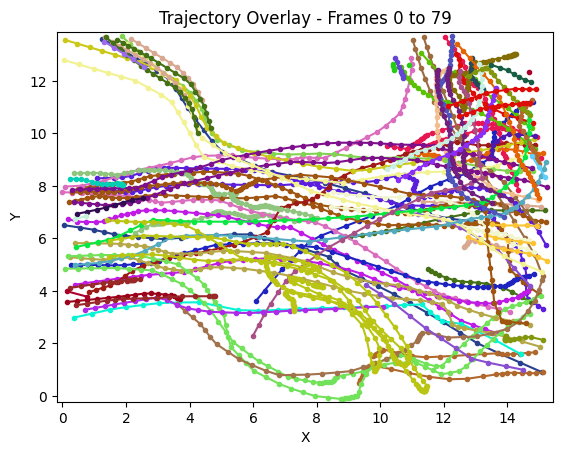

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# 读取数据
data_file_path = r'D:\xjtufiles\undergraduate\2023-2024\spring\ml\Pedestrian clustering\students003.txt'
cluster_file_path = r'D:\xjtufiles\undergraduate\2023-2024\spring\ml\Pedestrian clustering\ave_clustered_results.txt'

data = np.loadtxt(data_file_path)
cluster_data = np.loadtxt(cluster_file_path)

# 提取数据
timesteps = data[:, 0].astype(int)
ids = data[:, 1].astype(int)
xs = data[:, 2]
ys = data[:, 3]

# 获取聚类结果
cluster_ids = cluster_data[:].astype(int)  # 假设聚类结果文件中第一列是ID，第二列是聚类ID

# 获取唯一的时间步和唯一的ID
unique_timesteps = np.unique(timesteps)
unique_ids = np.unique(ids)

# 获取唯一的聚类ID
unique_cluster_ids = np.unique(cluster_ids)

# 分配随机颜色给每个聚类ID
np.random.seed(42)  # 固定种子，以保证相同运行环境的结果一致
colors = np.random.rand(len(unique_cluster_ids), 3)

# 创建图形
fig, ax = plt.subplots()
ax.set_xlim(np.min(xs), np.max(xs))
ax.set_ylim(np.min(ys), np.max(ys))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Trajectory Overlay - Frames 0 to 79')

# 绘制每个点的轨迹
for uid in unique_ids:
    mask = ids == uid
    user_timesteps = timesteps[mask]
    user_xs = xs[mask]
    user_ys = ys[mask]
    
    # 只绘制指定范围帧的轨迹
    trajectory_mask = user_timesteps < unique_timesteps[80]
    
    # 根据ID获取聚类ID，并从颜色列表中获取相应的颜色
    cluster_id = cluster_ids[uid - 1]  # 假设ID是从1开始的连续整数
    color = colors[cluster_id]
    
    ax.plot(user_xs[trajectory_mask], user_ys[trajectory_mask], color=color, marker='o', markersize=3)

# 保存图像
plt.savefig('trajectory_overlay_clusters.png')
plt.show()


只绘制部分时间帧下部分点的折线图

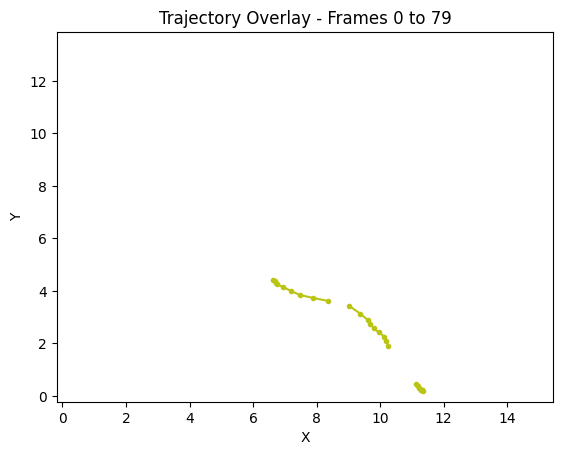

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# 读取数据
data_file_path = r'D:\xjtufiles\undergraduate\2023-2024\spring\ml\Pedestrian clustering\students003.txt'
cluster_file_path = r'D:\xjtufiles\undergraduate\2023-2024\spring\ml\Pedestrian clustering\ave_clustered_results.txt'

data = np.loadtxt(data_file_path)
cluster_data = np.loadtxt(cluster_file_path)

# 提取数据
timesteps = data[:, 0].astype(int)
ids = data[:, 1].astype(int)
xs = data[:, 2]
ys = data[:, 3]

# 获取聚类结果
cluster_ids = cluster_data[:].astype(int)  # 假设聚类结果文件中第一列是ID，第二列是聚类ID

# 定义要绘制的ID
specific_ids = {217,219,220}

# 获取唯一的时间步
unique_timesteps = np.unique(timesteps)

# 获取唯一的聚类ID
unique_cluster_ids = np.unique(cluster_ids)

# 分配随机颜色给每个聚类ID
np.random.seed(42)  # 固定种子，以保证相同运行环境的结果一致
colors = np.random.rand(len(unique_cluster_ids), 3)

# 创建图形
fig, ax = plt.subplots()
ax.set_xlim(np.min(xs), np.max(xs))
ax.set_ylim(np.min(ys), np.max(ys))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Trajectory Overlay - Frames 0 to 79')

# 绘制每个指定ID的轨迹
for uid in specific_ids:
    mask = ids == uid
    user_timesteps = timesteps[mask]
    user_xs = xs[mask]
    user_ys = ys[mask]
    
    # 只绘制指定范围帧的轨迹
    trajectory_mask = (user_timesteps < unique_timesteps[40]) &(user_timesteps > unique_timesteps[30])
    
    # 根据ID获取聚类ID，并从颜色列表中获取相应的颜色
    cluster_id = cluster_ids[uid - 1]  # 假设ID是从1开始的连续整数
    color = colors[cluster_id]
    
    ax.plot(user_xs[trajectory_mask], user_ys[trajectory_mask], color=color, marker='o', markersize=3)

# 保存图像
plt.savefig('trajectory_overlay_specific_ids.png')
plt.show()


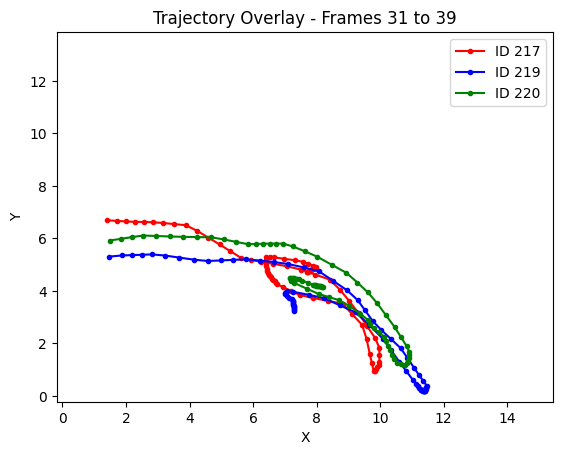

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# 读取数据
data_file_path = r'D:\xjtufiles\undergraduate\2023-2024\spring\ml\Pedestrian clustering\students003.txt'
cluster_file_path = r'D:\xjtufiles\undergraduate\2023-2024\spring\ml\Pedestrian clustering\ave_clustered_results.txt'

data = np.loadtxt(data_file_path)
cluster_data = np.loadtxt(cluster_file_path)

# 提取数据
timesteps = data[:, 0].astype(int)
ids = data[:, 1].astype(int)
xs = data[:, 2]
ys = data[:, 3]

# 获取聚类结果
cluster_ids = cluster_data[:].astype(int)  # 假设聚类结果文件中第一列是ID，第二列是聚类ID

# 定义要绘制的ID
specific_ids = [217, 219, 220]

# 获取唯一的时间步
unique_timesteps = np.unique(timesteps)

# 为每个指定ID手动分配颜色
color_map = {
    217: 'red',
    219: 'blue',
    220: 'green'
}

# 创建图形
fig, ax = plt.subplots()
ax.set_xlim(np.min(xs), np.max(xs))
ax.set_ylim(np.min(ys), np.max(ys))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Trajectory Overlay - Frames 31 to 39')

# 绘制每个指定ID的轨迹
for uid in specific_ids:
    mask = ids == uid
    user_timesteps = timesteps[mask]
    user_xs = xs[mask]
    user_ys = ys[mask]
    
    # 只绘制指定范围帧的轨迹
    trajectory_mask = (user_timesteps < unique_timesteps[80]) #& (user_timesteps > unique_timesteps[30])
    
    # 获取指定颜色
    color = color_map[uid]
    
    ax.plot(user_xs[trajectory_mask], user_ys[trajectory_mask], color=color, marker='o', markersize=3, label=f'ID {uid}')

# 添加图例
ax.legend()

# 保存图像
plt.savefig('trajectory_overlay_specific_ids_colored.png')
plt.show()


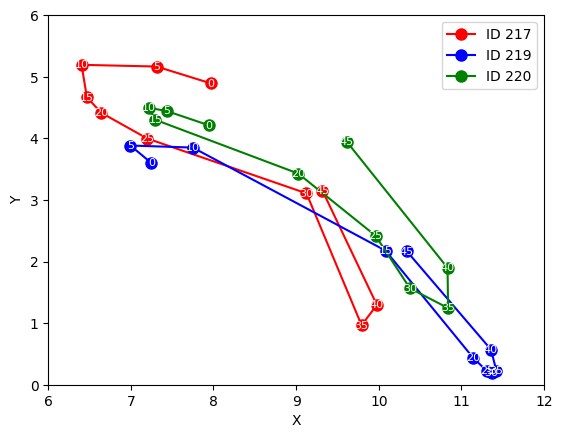

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# 读取数据
data_file_path = r'D:\xjtufiles\undergraduate\2023-2024\spring\ml\Pedestrian clustering\students003.txt'
cluster_file_path = r'D:\xjtufiles\undergraduate\2023-2024\spring\ml\Pedestrian clustering\ave_clustered_results.txt'

data = np.loadtxt(data_file_path)
cluster_data = np.loadtxt(cluster_file_path)

# 提取数据
timesteps = data[:, 0].astype(int)
ids = data[:, 1].astype(int)
xs = data[:, 2]
ys = data[:, 3]

# 获取聚类结果
cluster_ids = cluster_data[:].astype(int)  # 假设聚类结果文件中第一列是ID，第二列是聚类ID

# 定义要绘制的ID
specific_ids = [217, 219, 220]

# 获取唯一的时间步
unique_timesteps = np.unique(timesteps)

# 为每个指定ID手动分配颜色
color_map = {
    217: 'red',
    219: 'blue',
    220: 'green'
}

# 创建图形
fig, ax = plt.subplots()
ax.set_xlim(6, 12)  # 限制x范围
ax.set_ylim(0, 6)  # 限制y范围
ax.set_xlabel('X')
ax.set_ylabel('Y')
#ax.set_title('Trajectory Overlay - Frames 31 to 39')

# 绘制每个指定ID的轨迹
for uid in specific_ids:
    mask = ids == uid
    user_timesteps = timesteps[mask]
    user_xs = xs[mask]
    user_ys = ys[mask]
    
    # 只绘制指定范围帧的轨迹
    trajectory_mask = (user_timesteps < unique_timesteps[60]) & (user_timesteps > unique_timesteps[10])
    
    # 子采样每4帧取一个点
    subsampled_indices = np.arange(0, len(user_timesteps[trajectory_mask]), 5)
    
    # 获取指定颜色
    color = color_map[uid]
    
    # 绘制轨迹
    ax.plot(user_xs[trajectory_mask][subsampled_indices], user_ys[trajectory_mask][subsampled_indices], 
            color=color, marker='o', markersize=8, label=f'ID {uid}')
    
    # 在每个点上绘制时间步序号
    for i, (x, y) in enumerate(zip(user_xs[trajectory_mask][subsampled_indices], user_ys[trajectory_mask][subsampled_indices])):
        ax.text(x, y, str(i * 5), color='white', fontsize=8, ha='center', va='center')

# 添加图例
ax.legend()

# 保存图像
plt.savefig('trajectory_overlay_specific_ids_colored_numbered_zoomed.png')
plt.show()
